In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 - needed for 3D plots

from scipy.sparse import csr_matrix, csc_matrix, bsr_matrix


#  Recommender Example

In [25]:
data = {"Life is Beautiful":np.array([2.5, 3.0, 2.5, 'nan', 3, 3, 'nan'], dtype=np.double), "Seven Samurai": np.array([3.5, 3.5, 3.0, 3.5, 4, 4, 4.5], dtype=np.double),
        "Joker": np.array([3.0,1.5,'nan',3,2,'nan','nan'], dtype=np.double),  "Schindler's List": np.array([3.5,5,3.5,4.0,3,5,4], dtype=np.double), 
        "The Pianist": np.array([3,3,4,4.5,3,3,'nan'], dtype=np.double), "City Of God":np.array([2.5,3.5,'nan',3.0,2.0,3.5,1], dtype=np.double)}
users = ["Lee", "Sofia", "Miley", "Justina", "Donald", "Mickey", "Tristan"]
films = ["Life is Beautiful", "Seven Samurai","Joker","Schindler's List","The Pianist","City Of God"]
film_labels = ["Life", "Seven", "Joker", "List", "Pianist", "City"]
film_dict = dict(zip(films, film_labels))
df = pd.DataFrame(data, index = users)
df

,Life is Beautiful,Seven Samurai,Joker,Schindler's List,The Pianist,City Of God
Lee,2.5,3.5,3.0,3.5,3.0,2.5
Sofia,3.0,3.5,1.5,5.0,3.0,3.5
Miley,2.5,3.0,NaN,3.5,4.0,NaN
Justina,NaN,3.5,3.0,4.0,4.5,3.0
Donald,3.0,4.0,2.0,3.0,3.0,2.0
Mickey,3.0,4.0,NaN,5.0,3.0,3.5
Tristan,NaN,4.5,NaN,4.0,NaN,1.0


# Content-based Approach

In this mini-demo we **ignore other users** and only use simple
*content features* for each film (how romantic / how action-heavy it is)
plus one user's ratings to learn that user's taste.


In [26]:
# Content features for each movie: x1 = romance, x2 = action (values in [0,1])
movie_features = pd.DataFrame(
    {
        "romance": {
            "Life is Beautiful": 0.9,
            "Seven Samurai":    0.2,
            "Joker":            0.1,
            "Schindler's List": 0.4,
            "The Pianist":      0.5,
            "City Of God":      0.2,
        },
        "action": {
            "Life is Beautiful": 0.2,
            "Seven Samurai":    0.9,
            "Joker":            0.8,
            "Schindler's List": 0.4,
            "The Pianist":      0.3,
            "City Of God":      0.9,
        },
    }
)

# movie_features
movie_features.T

,Life is Beautiful,Seven Samurai,Joker,Schindler's List,The Pianist,City Of God
romance,0.9,0.2,0.1,0.4,0.5,0.2
action,0.2,0.9,0.8,0.4,0.3,0.9


In [27]:
def plot_user_movies_3d(user="Miley", ratings=df, movie_features=movie_features, min_ratings=2):
    """
    Plot the films rated by `user` in 3D:
    x = action, y = romance, z = rating.
    """
    if user not in ratings.index:
        print(f"User '{user}' not found ")
        return
    
    user_row = ratings.loc[user]
    user_ratings = user_row.dropna()   # only films they actually rated
    
    if len(user_ratings) < min_ratings:
        print(f"{user} has only {len(user_ratings)} rating(s) – not enough points to plot nicely.")
        return
    
    feats = movie_features.loc[user_ratings.index]   # romance, action for those films
    
    xs = feats["action"].values
    ys = feats["romance"].values
    zs = user_ratings.values
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    
    # scatter points
    ax.scatter(xs, ys, zs, s=60, c="tab:blue")
    
    # label each film
    for title, x, y, z in zip(feats.index, xs, ys, zs):
        ax.text(x, y, z, f"{title}\n({z:.1f})", fontsize=8)
    
    ax.set_xlabel("Action")
    ax.set_ylabel("Romance")
    ax.set_zlabel("Rating (1–5 stars)")  # <- clearer label for the rating axis
    ax.set_title(f"Films rated by {user} in (action, romance, rating) space")
    
    plt.show()




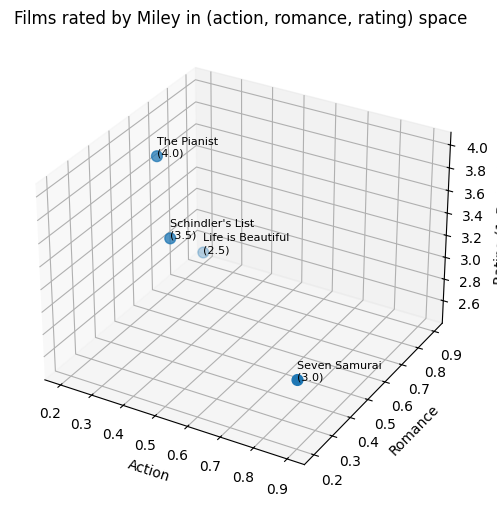

In [28]:
plot_user_movies_3d("Miley")

In [29]:
def content_based_predict(user, ratings=df, movie_features=movie_features, min_ratings=2):
    """Fit a simple content-based linear model for one user and
    predict their missing movie ratings, and visualise their taste.
    """
    if user not in ratings.index:
        print(f"User '{user}' not found :(")
        return

    user_row = ratings.loc[user]
    user_ratings = user_row.dropna()

    if len(user_ratings) < min_ratings:
        print(f"{user} has only {len(user_ratings)} rating(s) – not enough data to learn a profile.")
        return

    # --- Training data ---
    X_train = movie_features.loc[user_ratings.index]          # romance, action
    X_design = np.c_[np.ones(len(X_train)), X_train.values]   # [1, x1, x2]
    y = user_ratings.values

    theta, *_ = np.linalg.lstsq(X_design, y, rcond=None)
    b, w1, w2 = theta

    print(f"=== Content-based model for {user} ===")
    print("\nUsed these movies to learn their taste:")
    display(pd.concat([user_ratings, X_train], axis=1).rename(columns={user: "rating"}))

    print("\nLearned rating formula:")
    print(f"  rating ≈ {b:.2f} + {w1:.2f}·romance + {w2:.2f}·action")

    # Tiny "personality" summary
    if abs(w1 - w2) < 0.2:
        pref = "likes a balance of romance and action."
    elif w1 > w2:
        pref = "seems to be more into ROMANCE."
    else:
        pref = "seems to be more into ACTION."
    print(f"\nFrom this model, {user} {pref}")

    # Visualise the user's rated films and preference direction
    # plot_content_space(user, ratings, movie_features, theta=theta)

    # --- Predictions for missing movies ---
    missing_movies = user_row[user_row.isna()].index
    if len(missing_movies) == 0:
        print(f"\nNo missing ratings for {user} – they've rated everything already!")
        return

    X_test = movie_features.loc[missing_movies].values
    X_test_design = np.c_[np.ones(len(X_test)), X_test]
    pred_ratings = X_test_design @ theta

    pred_df = pd.DataFrame(
        {
            "predicted_rating": np.round(pred_ratings, 2),
            "romance": movie_features.loc[missing_movies, "romance"],
            "action":  movie_features.loc[missing_movies, "action"],
        },
        index=missing_movies,
    ).sort_values("predicted_rating", ascending=False)

    print(f"\nPredicted ratings for {user}'s unseen movies (content-based):")
    display(pred_df)

def plot_content_regression_3d(user="Miley", ratings=df, movie_features=movie_features, min_ratings=2):
    """
    Side-by-side regression demo for one user.

    LEFT:
      - Rated films as blue points in 3D
      - Fitted regression plane: rating ≈ b + w1*romance + w2*action
    RIGHT:
      - Same plane + rated films (light grey)
      - Predicted ratings for 'Joker' and 'City Of God' as red points
    """
    if user not in ratings.index:
        print(f"User '{user}' not found")
        return
    
    user_row = ratings.loc[user]
    user_ratings = user_row.dropna()
    
    if len(user_ratings) < min_ratings:
        print(f"{user} has only {len(user_ratings)} rating(s) – not enough data to fit a model.")
        return
    
    # Training features and targets
    X_train = movie_features.loc[user_ratings.index]          # romance, action
    # Design matrix: [1, romance, action]
    X_design = np.c_[np.ones(len(X_train)),
                     X_train["romance"].values,
                     X_train["action"].values]
    y = user_ratings.values
    
    # Fit θ = (b, w1, w2) by least squares
    theta, *_ = np.linalg.lstsq(X_design, y, rcond=None)
    b, w1, w2 = theta
    
    # For plotting: use action on x-axis, romance on y-axis
    action_vals = X_train["action"].values
    romance_vals = X_train["romance"].values
    rating_vals = y
    
    # Create a grid over (action, romance) to draw the fitted plane
    a_min, a_max = action_vals.min() - 0.1, action_vals.max() + 0.1
    r_min, r_max = romance_vals.min() - 0.1, romance_vals.max() + 0.1
    a_surf = np.linspace(a_min, a_max, 20)
    r_surf = np.linspace(r_min, r_max, 20)
    A_surf, R_surf = np.meshgrid(a_surf, r_surf)
    Z_surf = b + w1 * R_surf + w2 * A_surf   # w1 on romance, w2 on action
    
    # Prepare predictions for Joker and City Of God
    target_movies = ["Joker", "City Of God"]
    target_movies = [m for m in target_movies if m in movie_features.index]
    feats_pred = movie_features.loc[target_movies]
    action_pred = feats_pred["action"].values
    romance_pred = feats_pred["romance"].values
    Z_pred = b + w1 * romance_pred + w2 * action_pred
    
    # ---- Create side-by-side plots ----
    fig = plt.figure(figsize=(14, 6))
    
    # LEFT: fit to existing points
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.scatter(action_vals, romance_vals, rating_vals,
                c="tab:blue", s=60, label="Rated films")
    
    for title, a, r, z in zip(X_train.index, action_vals, romance_vals, rating_vals):
        ax1.text(a, r, z, f"{title}\n({z:.1f})", fontsize=8)
    
    ax1.plot_surface(A_surf, R_surf, Z_surf,
                     alpha=0.3, color="tab:blue")
    
    ax1.set_xlabel("Action")
    ax1.set_ylabel("Romance")
    ax1.set_zlabel("Rating (1–5 stars)")
    ax1.set_title(f"{user}'s ratings and fitted regression plane")
    ax1.legend()
    
    # RIGHT: predicted points for Joker & City Of God
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    
    # Show existing rated films lightly for context
    ax2.scatter(action_vals, romance_vals, rating_vals,
                c="lightgrey", s=40, label="Rated films")
    ax2.plot_surface(A_surf, R_surf, Z_surf,
                     alpha=0.2, color="tab:blue")
    
    # Predicted points in red
    ax2.scatter(action_pred, romance_pred, Z_pred,
                c="red", s=80, label="Predicted rating")
    for title, a, r, z in zip(target_movies, action_pred, romance_pred, Z_pred):
        ax2.text(a, r, z, f"{title}\n({z:.2f})", color="red", fontsize=9)
    
    ax2.set_xlabel("Action")
    ax2.set_ylabel("Romance")
    ax2.set_zlabel("Rating (1–5 stars)")
    ax2.set_title(f"{user}: predicted ratings for Joker & City Of God")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


=== Content-based model for Miley ===

Used these movies to learn their taste:


,rating,romance,action
Life is Beautiful,2.5,0.9,0.2
Seven Samurai,3.0,0.2,0.9
Schindler's List,3.5,0.4,0.4
The Pianist,4.0,0.5,0.3



Learned rating formula:
  rating ≈ 6.53 + -3.73·romance + -3.13·action

From this model, Miley seems to be more into ACTION.

Predicted ratings for Miley's unseen movies (content-based):


,predicted_rating,romance,action
Joker,3.65,0.1,0.8
City Of God,2.96,0.2,0.9


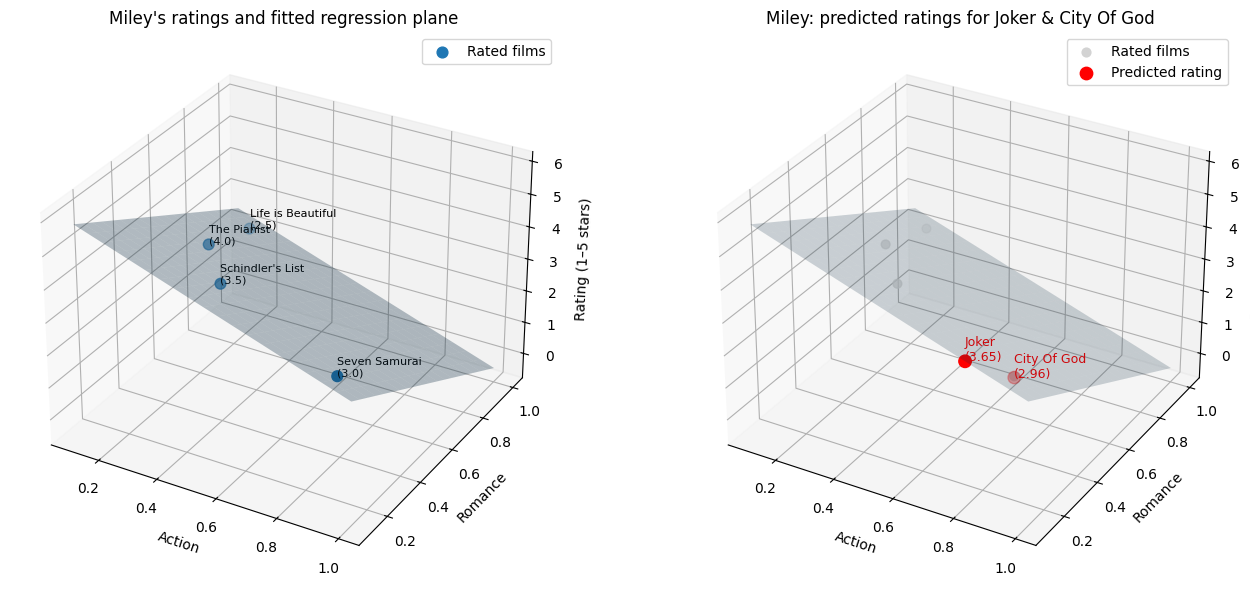

In [30]:
# Try this live in class: ask students to pick a user name

content_based_predict("Miley")
plot_content_regression_3d("Miley")     # 3D view: romance–action–rating + regression plane

# Collaborative Approach: user-based filtering

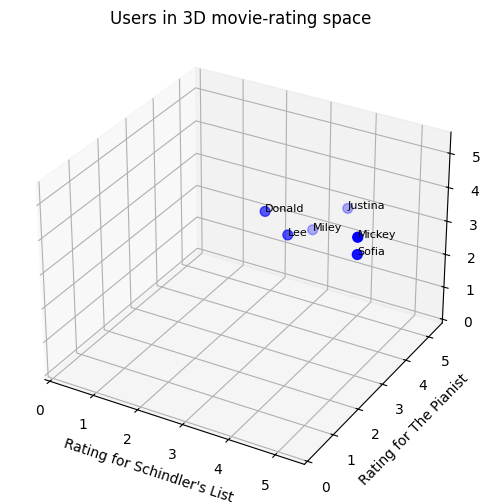

In [31]:
x = "Schindler's List"
y = "The Pianist"
z = "Seven Samurai"

# Mask: users who rated all three films
plot_mask = df[[x, y, z]].notna().all(axis=1)
# If you want to restrict to a specific list of users:
# plot_mask &= df.index.isin(users)

x_vals = df.loc[plot_mask, x]
y_vals = df.loc[plot_mask, y]
z_vals = df.loc[plot_mask, z]

from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# 3D scatter: x = rating for Schindler's List, y = rating for The Pianist, z = rating for Life is Beautiful
ax.scatter(x_vals, y_vals, z_vals, c="b", s=50)

# Label each point with the user name
for user in x_vals.index:
    ax.text(x_vals[user], y_vals[user], z_vals[user], user, fontsize=8)

ax.set_xlabel(f"Rating for {x}")
ax.set_ylabel(f"Rating for {y}")
ax.set_zlabel(f"Rating for {z} (1–5 stars)")

ax.set_xlim(0, 5.5)
ax.set_ylim(0, 5.5)
ax.set_zlim(0, 5.5)
ax.grid(True)
ax.set_title("Users in 3D movie-rating space")

plt.show()

In [32]:
x = "Schindler's List"
y = "The Pianist"
z = "Seven Samurai"

# Users who rated all three films
plot_mask = df[[x, y, z]].notna().all(axis=1)

# Subset of ratings: rows = users, columns = the 3 films
user_triplets = df.loc[plot_mask, [x, y, z]].astype(float)
user_triplets

,Schindler's List,The Pianist,Seven Samurai
Lee,3.5,3.0,3.5
Sofia,5.0,3.0,3.5
Miley,3.5,4.0,3.0
Justina,4.0,4.5,3.5
Donald,3.0,3.0,4.0
Mickey,5.0,3.0,4.0


In [33]:
# Pearson correlation between USERS (rows),
# using their 3D rating vectors (x,y,z)
user_corr = user_triplets.T.corr()   # transpose so corr is over users
user_corr

,Lee,Sofia,Miley,Justina,Donald,Mickey
Lee,1.000000,0.693375,-0.866025,-0.866025,0.500000,0.866025
Sofia,0.693375,1.000000,-0.240192,-0.240192,-0.277350,0.960769
Miley,-0.866025,-0.240192,1.000000,1.000000,-0.866025,-0.500000
Justina,-0.866025,-0.240192,1.000000,1.000000,-0.866025,-0.500000
Donald,0.500000,-0.277350,-0.866025,-0.866025,1.000000,0.000000
Mickey,0.866025,0.960769,-0.500000,-0.500000,0.000000,1.000000


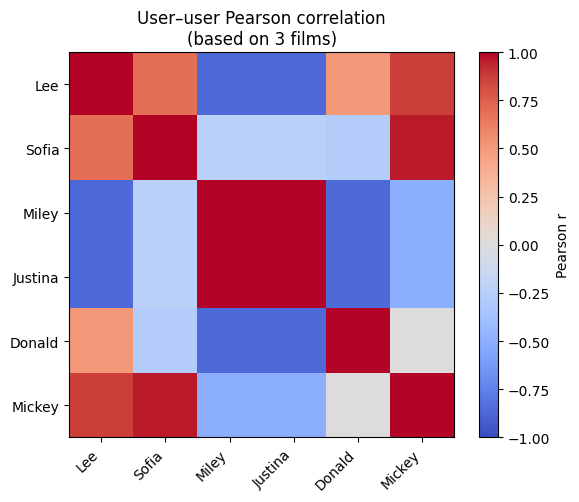

In [34]:
# Heatmap of user–user Pearson correlations
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(user_corr, vmin=-1, vmax=1, cmap="coolwarm")

users_in_plot = user_corr.index.tolist()

ax.set_xticks(np.arange(len(users_in_plot)))
ax.set_xticklabels(users_in_plot, rotation=45, ha="right")

ax.set_yticks(np.arange(len(users_in_plot)))
ax.set_yticklabels(users_in_plot)

ax.set_title("User–user Pearson correlation\n(based on 3 films)")
fig.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()

# Ranking users by similarity

In [35]:
def euclid_dist(x, y):
    diff = x - y
    return np.sqrt(np.sum(diff**2))

def euclid_sim(x, y):
    dist = euclid_dist(x, y)
    return 1.0 / (1.0 + dist)

def cos_sim(x, y):
    num = np.dot(x, y)
    den = np.sqrt(np.sum(x**2)) * np.sqrt(np.sum(y**2))
    if den == 0:
        return 0.0
    return num / den

def pearson(x, y):
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    num = np.dot(x - x_bar, y - y_bar)
    den = np.sqrt(np.sum((x - x_bar)**2)) * np.sqrt(np.sum((y - y_bar)**2))
    if den == 0:
        return 0.0   # zero variance → undefined correlation → treat as 0 similarity
    return num / den

def common_ratings(user1, user2, ratings):
    """
    Return (x, y) = numpy arrays of ratings for items that both users have rated.
    """
    s1 = ratings.loc[user1]
    s2 = ratings.loc[user2]
    mask = (~s1.isna()) & (~s2.isna())
    if mask.sum() == 0:
        return None, None
    return s1[mask].values.astype(float), s2[mask].values.astype(float)

def rank(user1, ratings, sim=pearson, n=None, print_out=True):
    """
    Rank other users by similarity to user1 using the given similarity function.
    sim must take two numpy arrays (x, y) and return a scalar similarity.
    """
    users = list(ratings.index)
    if user1 not in users:
        raise ValueError(f"User '{user1}' not found in ratings index")

    if n is None:
        n = len(users) - 1

    similarities = {}
    for user2 in users:
        if user2 == user1:
            continue
        x, y = common_ratings(user1, user2, ratings)
        if x is None:          # no overlap
            continue
        s = sim(x, y)
        similarities[user2] = s

    # sort by similarity descending
    sorted_pairs = sorted(similarities.items(),
                          key=lambda kv: kv[1],
                          reverse=True)[:n]

    if print_out:
        print(f"Top {n} closest to {user1}:\n")
        for other, s in sorted_pairs:
            print(f"{other:8s}  {s:.3f}")
        print()

    return sorted_pairs

def plot_user_neighbours(user, ratings, sim=pearson, k=5):
    """
    Plot the top-k most similar users to the given user
    (user-based collaborative filtering intuition).
    """
    top = rank(user, ratings, sim=sim, n=k, print_out=False)
    if not top:
        print(f"No neighbours found for {user}")
        return

    names  = [u for u, _ in top]
    values = [v for _, v in top]

    plt.figure(figsize=(6, 4))
    plt.bar(names, values)
    plt.ylabel("Similarity")
    plt.ylim(-1, 1)
    plt.title(f"Top {k} neighbours for {user}")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

Using Pearson similarity

Top 6 closest to Miley:

Justina   1.000
Lee       0.405
Sofia     0.205
Mickey    0.135
Donald    -0.258
Tristan   -1.000



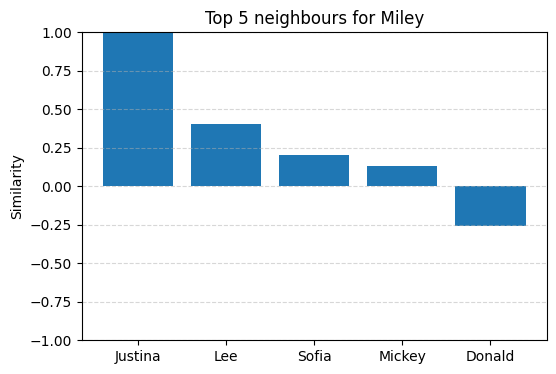

In [36]:
u1 = "Miley"

print("Using Pearson similarity\n")
top_matches = rank(u1, df, sim=pearson)   # or sim=cos_sim / euclid_sim

plot_user_neighbours(u1, ratings=df, sim=pearson, k=5)

“These are Miley’s nearest neighbours by Pearson similarity. 

user-based CF will now look at what films those neighbours liked that Miley hasn’t seen yet, and use that to predict her ratings for Joker and City Of God.”

In [37]:
def common_ratings(user1, user2, ratings):
    """
    Return numpy arrays (x, y) of ratings for items that both users rated.
    """
    s1 = ratings.loc[user1]
    s2 = ratings.loc[user2]
    mask = (~s1.isna()) & (~s2.isna())
    if mask.sum() == 0:
        return None, None
    return s1[mask].values.astype(float), s2[mask].values.astype(float)

In [38]:
import numpy as np
import math

def predict_user_based_rating(user, item, ratings, sim_func=pearson, k=None, min_common=1):
    """
    Predict rating r_{user,item} using user-based collaborative filtering.

    r_{u,i} = sum_{u_hat in U} sim(u,u_hat) * r_{u_hat,i}  /  sum_{u_hat in U} |sim(u,u_hat)|

    - U: set of top-k users most similar to `user` who have rated `item`
    - sim_func: similarity function on numpy arrays (e.g. pearson, cos_sim)
    - k: number of neighbours (if None, use all users who rated the item)
    """
    if item not in ratings.columns:
        raise ValueError(f"Item '{item}' not in ratings columns")
    if user not in ratings.index:
        raise ValueError(f"User '{user}' not in ratings index")

    sims_and_ratings = []

    for other in ratings.index:
        if other == user:
            continue
        # must have rated the target item
        r_oi = ratings.loc[other, item]
        if np.isnan(r_oi):
            continue

        x, y = common_ratings(user, other, ratings)
        if x is None or len(x) < min_common:
            continue

        s = sim_func(x, y)
        # if similarity is 0, this neighbour carries no weight anyway
        sims_and_ratings.append((other, s, r_oi))

    if not sims_and_ratings:
        return math.nan, []

    # sort neighbours by similarity, highest first
    sims_and_ratings.sort(key=lambda t: t[1], reverse=True)
    if k is not None:
        sims_and_ratings = sims_and_ratings[:k]

    # apply the formula from the slide
    num = sum(s * r for (_, s, r) in sims_and_ratings)
    den = sum(abs(s) for (_, s, _) in sims_and_ratings)

    if den == 0:
        pred = math.nan
    else:
        pred = num / den

    return pred, sims_and_ratings

In [39]:
import matplotlib.pyplot as plt
import math

def demo_user_based_for_miley_side_by_side(ratings=df, sim_func=pearson, k=3):
    user = "Miley"
    target_items = ["Joker", "City Of God"]

    # compute predictions + neighbour contributions for each target film
    results = {}
    for item in target_items:
        pred, contrib = predict_user_based_rating(
            user=user,
            item=item,
            ratings=ratings,
            sim_func=sim_func,
            k=k
        )
        results[item] = (pred, contrib)

    # ---- side-by-side plots ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for ax, item in zip(axes, target_items):
        pred, contrib = results[item]
        if not contrib:
            ax.set_title(f"No neighbours for '{item}'")
            ax.set_xlabel("Neighbour")
            ax.set_ylabel("Rating (1–5 stars)")
            continue

        names  = [other for (other, _, _) in contrib]
        scores = [r for (_, _, r) in contrib]
        sims   = [s for (_, s, _) in contrib]

        ax.bar(names, scores, color="tab:blue")
        ax.set_ylim(0, 5.5)
        ax.set_ylabel("Rating (1–5 stars)")
        ax.set_xlabel("Similar user")
        ax.set_title(f"{user}'s neighbours for '{item}'")
        ax.set_xticklabels(names, rotation=30, ha="right")

        # annotate similarities
        for i, (name, rating, s) in enumerate(zip(names, scores, sims)):
            ax.text(i, rating + 0.1, f"sim={s:.2f}", ha="center", fontsize=8)

        # predicted rating line
        if not math.isnan(pred):
            ax.axhline(pred, color="red", linestyle="--",
                       label=f"predicted = {pred:.2f}")
            ax.legend()

    plt.suptitle(f"User-based CF for {user}: Joker vs City Of God")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # print numeric predictions underneath
    print(f"User-based CF predictions for {user}:")
    for item in target_items:
        pred, _ = results[item]
        if math.isnan(pred):
            print(f"  {item}: no prediction available")
        else:
            print(f"  {item}: {pred:.2f}")

/var/folders/xd/165ghff513x79ys3lrzbwc340000gn/T/ipykernel_1211/3111375059.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=30, ha="right")
/var/folders/xd/165ghff513x79ys3lrzbwc340000gn/T/ipykernel_1211/3111375059.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=30, ha="right")


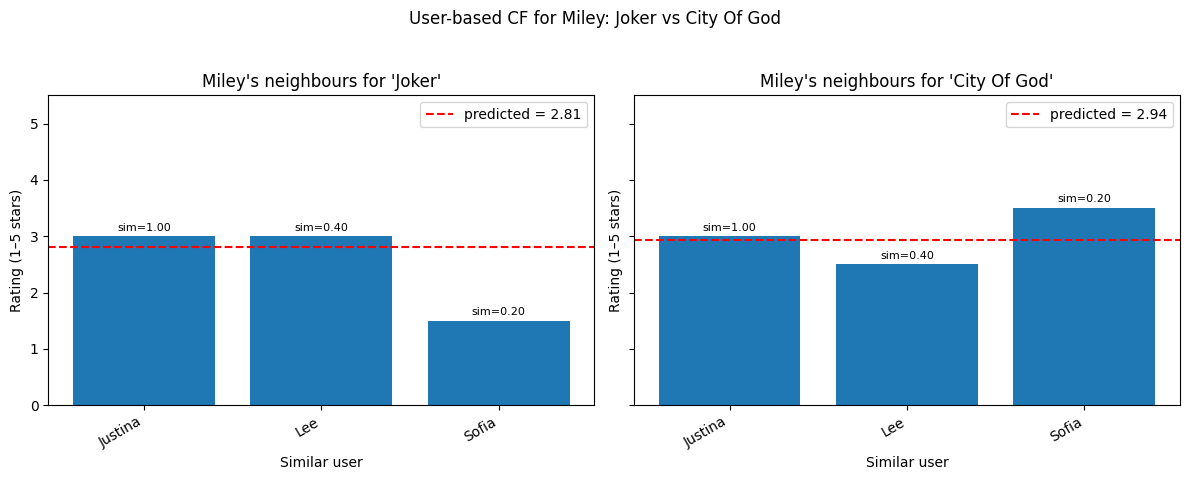

User-based CF predictions for Miley:
  Joker: 2.81
  City Of God: 2.94


In [40]:
demo_user_based_for_miley_side_by_side(df, sim_func=pearson, k=3)

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_user_triangle_joker_cog(points, weights, labels, title="User-based barycentric interpolation"):
    """
    points  : array-like (3, 2)  -> (rating for Joker, rating for City Of God) for 3 neighbour users
    weights : array-like (3,)    -> similarity weights for those neighbours
    labels  : list of 3 user names
    """
    points = np.asarray(points, float)
    weights = np.asarray(weights, float)

    # Use non-negative weights for a clean barycentric picture
    w = np.abs(weights)
    if np.allclose(w.sum(), 0):
        w_norm = np.ones_like(w) / 3.0
    else:
        w_norm = w / w.sum()

    # Barycentric (weighted) combination -> predicted point
    p_pred = (w_norm[:, None] * points).sum(axis=0)

    fig, ax = plt.subplots(figsize=(5, 5))

    # Draw triangle
    tri = np.vstack([points, points[0]])  # close the loop
    ax.plot(tri[:, 0], tri[:, 1], "k--", alpha=0.4)

    # Neighbour users (vertices)
    ax.scatter(points[:, 0], points[:, 1], s=120, c="tab:blue", label="neighbour users")
    for (x, y), name, wn in zip(points, labels, w_norm):
        ax.text(x, y + 0.07, f"{name}\nw={wn:.2f}", ha="center", va="bottom", fontsize=9)

    # Predicted Miley point as barycentric combo
    ax.scatter(p_pred[0], p_pred[1], s=160, c="red", marker="*",
               label="predicted Miley\n(Joker, City of God)")
    ax.text(p_pred[0], p_pred[1] - 0.08, "prediction", ha="center", va="top", fontsize=9)

    # Guide lines from vertices to the prediction point
    for (x, y) in points:
        ax.plot([x, p_pred[0]], [y, p_pred[1]], "gray", alpha=0.3)

    ax.set_xlabel("Rating for 'Joker'")
    ax.set_ylabel("Rating for 'City Of God'")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0.5, 5.5)
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()

    return p_pred

In [42]:
def pearson_similarity_user(user1, user2, ratings):
    """
    Compute Pearson correlation between two users.
    ratings: pandas DataFrame (rows = users, cols = items)
    """

    # Get ratings of both users
    r1 = ratings.loc[user1]
    r2 = ratings.loc[user2]

    # Only keep co-rated items
    common = r1.notna() & r2.notna()
    r1 = r1[common]
    r2 = r2[common]

    if len(r1) == 0:
        return 0  # no overlap

    # Mean-center
    r1_centered = r1 - r1.mean()
    r2_centered = r2 - r2.mean()

    numerator = np.sum(r1_centered * r2_centered)
    denominator = np.sqrt(np.sum(r1_centered**2)) * np.sqrt(np.sum(r2_centered**2))

    if denominator == 0:
        return 0

    return numerator / denominator

In [43]:
def demo_user_based_triangle_joker_cog(target_user="Miley", ratings=df, sim_func=pearson_similarity_user,k=3):
    
    target_items = ["Joker", "City Of God"]

    # 1) collect candidate neighbours: must have ratings for BOTH Joker & City Of God
    candidates = []
    for other in ratings.index:
        if other == target_user:
            continue

        # must have rated both target films
        if ratings.loc[other, target_items].isna().any():
            continue

        # compute similarity on all co-rated items (you can exclude Joker/CityOfGod if you like)
        s = sim_func(target_user, other, ratings)
        candidates.append((other, s))

    if len(candidates) < 3:
        print("Not enough neighbours who rated both Joker and City Of God.")
        return

    # 2) take top-k neighbours by similarity
    candidates.sort(key=lambda t: t[1], reverse=True)
    neighbours = candidates[:k]
    neighbour_names = [u for u, _ in neighbours]
    weights = np.array([s for _, s in neighbours], float)

    # 3) build 2D coordinates: (rating on Joker, rating on City Of God)
    coords = ratings.loc[neighbour_names, target_items].values.astype(float)

    print(f"Target user: {target_user}")
    print("Neighbours (used for barycentric combination):")
    for name, w, (r_jok, r_cog) in zip(neighbour_names, weights, coords):
        print(f"  {name:8s}  sim={w:.3f},  Joker={r_jok:.1f},  CityOfGod={r_cog:.1f}")

    # 4) show triangle interpolation in (Joker, CityOfGod) space
    p_pred = plot_user_triangle_joker_cog(
        points=coords,
        weights=weights,
        labels=neighbour_names,
        title=f"User-based CF: Miley as barycentric combo of 3 neighbours"
    )

    # 5) print the predicted ratings from this barycentric view
    print(f"\nBarycentric prediction for {target_user}:")
    print(f"  Joker:       {p_pred[0]:.2f}")
    print(f"  City Of God: {p_pred[1]:.2f}")

Target user: Miley
Neighbours (used for barycentric combination):
  Justina   sim=1.000,  Joker=3.0,  CityOfGod=3.0
  Lee       sim=0.405,  Joker=3.0,  CityOfGod=2.5
  Sofia     sim=0.205,  Joker=1.5,  CityOfGod=3.5


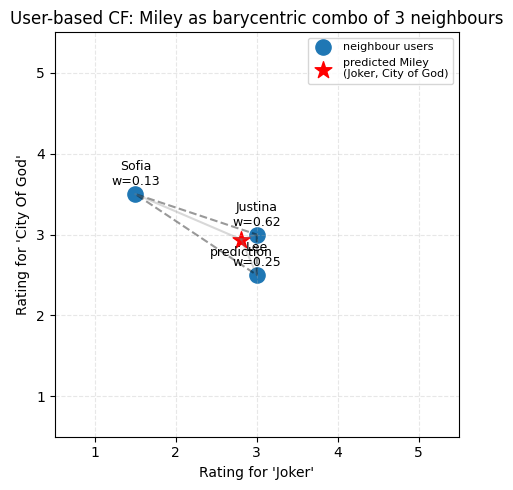


Barycentric prediction for Miley:
  Joker:       2.81
  City Of God: 2.94


In [44]:
demo_user_based_triangle_joker_cog("Miley", ratings=df)

# Collaborative Approach: item-based filtering

Space of items in 3D (each point is a film)

Pick three users as axes (e.g. Lee, Sofia, Miley) and plot each film as a point:

x = Lee’s rating, y = Sofia’s rating, z = Miley’s rating.

In [45]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D
import matplotlib.pyplot as plt
import numpy as np

def plot_item_space_3d(ratings=df, users_for_axes=("Lee", "Sofia", "Miley")):
    """
    Plot films in 3D using three users' ratings as axes:
    x = rating by users_for_axes[0]
    y = rating by users_for_axes[1]
    z = rating by users_for_axes[2]
    """
    u1, u2, u3 = users_for_axes

    # Only films rated by all three chosen users
    mask = ratings.loc[[u1, u2, u3]].notna().all(axis=0)
    films = ratings.columns[mask]

    if len(films) == 0:
        print("No films rated by all three chosen users.")
        return

    x_vals = ratings.loc[u1, films].astype(float)
    y_vals = ratings.loc[u2, films].astype(float)
    z_vals = ratings.loc[u3, films].astype(float)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(x_vals, y_vals, z_vals, c="tab:orange", s=60)

    for film in films:
        ax.text(x_vals[film], y_vals[film], z_vals[film], film, fontsize=8)

    ax.set_xlabel(f"Rating by {u1}")
    ax.set_ylabel(f"Rating by {u2}")
    ax.set_zlabel(f"Rating by {u3} (1–5 stars)")
    ax.set_xlim(0, 5.5)
    ax.set_ylim(0, 5.5)
    ax.set_zlim(0, 5.5)
    ax.set_title("Films in 3D rating space (item view)")
    ax.grid(True)

    plt.show()

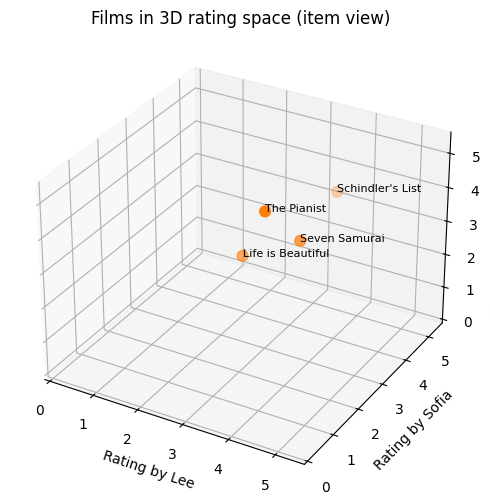

In [46]:
plot_item_space_3d(df, users_for_axes=("Lee", "Sofia", "Miley"))

In [47]:
def common_ratings_items(item1, item2, ratings=df):
    """
    Return numpy arrays (x, y) for ratings of users who rated both items.
    """
    s1 = ratings[item1]
    s2 = ratings[item2]
    mask = (~s1.isna()) & (~s2.isna())
    if mask.sum() == 0:
        return None, None
    return s1[mask].values.astype(float), s2[mask].values.astype(float)

def rank_items(item, ratings=df, sim_func=pearson, n=5, print_out=True):
    """
    Rank other films by similarity to `item` using the given similarity function.
    """
    if item not in ratings.columns:
        raise ValueError(f"Item '{item}' not found in ratings columns")

    sims = {}
    for other in ratings.columns:
        if other == item:
            continue
        x, y = common_ratings_items(item, other, ratings)
        if x is None:   # no overlap
            continue
        s = sim_func(x, y)
        sims[other] = s

    top = sorted(sims.items(), key=lambda kv: kv[1], reverse=True)[:n]

    if print_out:
        print(f"Top {n} items similar to '{item}':\n")
        for film, s in top:
            print(f"{film:20s}  {s:.3f}")
        print()

    return top

def plot_item_neighbours(item, ratings=df, sim_func=pearson, k=5):
    """
    Plot the top-k most similar items to a given film.
    """
    top = rank_items(item, ratings=ratings, sim_func=sim_func, n=k, print_out=False)
    if not top:
        print(f"No similar items found for '{item}'")
        return

    names  = [f for f, _ in top]
    values = [s for _, s in top]

    plt.figure(figsize=(6, 4))
    plt.bar(names, values)
    plt.ylabel("Similarity")
    plt.ylim(-1, 1)
    plt.title(f"Top {k} neighbours for '{item}'")
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

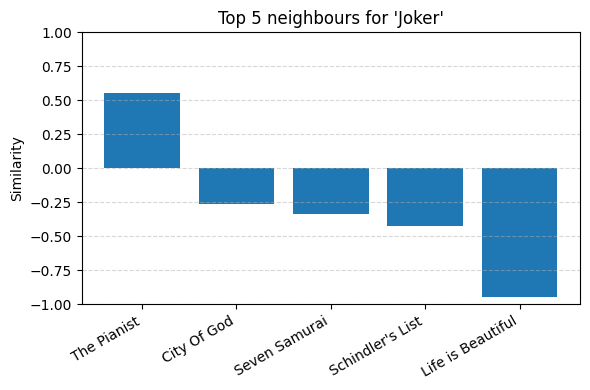

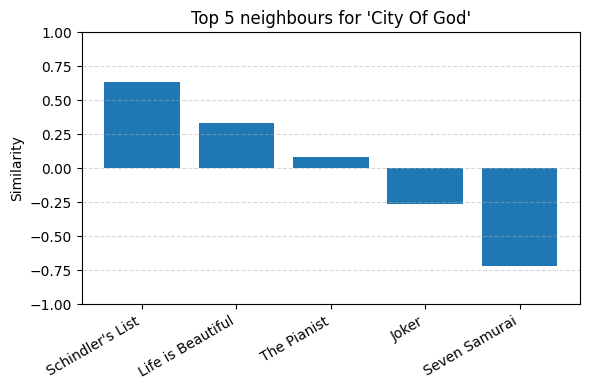

In [48]:
plot_item_neighbours("Joker", ratings=df, sim_func=pearson, k=5)
plot_item_neighbours("City Of God", ratings=df, sim_func=pearson, k=5)

In [49]:
import math

def predict_item_based_rating(user, item, ratings=df, sim_func=pearson, k=3, min_common=1):
    """
    Predict rating r_{user,item} using item-based collaborative filtering.

    r_{u,i} = sum_{j in N(i)} sim(i,j) * r_{u,j} / sum_{j in N(i)} |sim(i,j)|

    - N(i): top-k items most similar to `item` that `user` has rated
    """
    if item not in ratings.columns:
        raise ValueError(f"Item '{item}' not in ratings")
    if user not in ratings.index:
        raise ValueError(f"User '{user}' not in ratings")

    neighbours = []

    for other_item in ratings.columns:
        if other_item == item:
            continue
        # user must have rated this neighbour item
        r_u_other = ratings.loc[user, other_item]
        if np.isnan(r_u_other):
            continue

        x, y = common_ratings_items(item, other_item, ratings)
        if x is None or len(x) < min_common:
            continue

        s = sim_func(x, y)
        neighbours.append((other_item, s, r_u_other))

    if not neighbours:
        return math.nan, []

    # sort neighbours by similarity
    neighbours.sort(key=lambda t: t[1], reverse=True)
    if k is not None:
        neighbours = neighbours[:k]

    num = sum(s * r for (_, s, r) in neighbours)
    den = sum(abs(s) for (_, s, _) in neighbours)

    pred = math.nan if den == 0 else num / den
    return pred, neighbours

In [50]:
def demo_item_based_for_miley_side_by_side(ratings=df, sim_func=pearson, k=3):
    user = "Miley"
    target_items = ["Joker", "City Of God"]

    results = {}
    for item in target_items:
        pred, contrib = predict_item_based_rating(
            user=user,
            item=item,
            ratings=ratings,
            sim_func=sim_func,
            k=k
        )
        results[item] = (pred, contrib)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for ax, item in zip(axes, target_items):
        pred, contrib = results[item]
        if not contrib:
            ax.set_title(f"No neighbours for '{item}'")
            ax.set_xlabel("Neighbour film")
            ax.set_ylabel("Rating (1–5 stars)")
            continue

        names  = [film for (film, _, _) in contrib]
        scores = [r for (_, _, r) in contrib]
        sims   = [s for (_, s, _) in contrib]

        ax.bar(names, scores, color="tab:blue")
        ax.set_ylim(0, 5.5)
        ax.set_ylabel("Rating (1–5 stars)")
        ax.set_xlabel("Similar film")
        ax.set_title(f"{user}'s neighbours for '{item}'")
        ax.set_xticklabels(names, rotation=30, ha="right")

        # annotate similarities
        for i, (name, rating, s) in enumerate(zip(names, scores, sims)):
            ax.text(i, rating + 0.1, f"sim={s:.2f}", ha="center", fontsize=8)

        # predicted rating line
        if not math.isnan(pred):
            ax.axhline(pred, color="red", linestyle="--",
                       label=f"predicted = {pred:.2f}")
            ax.legend()

    plt.suptitle(f"Item-based CF for {user}: Joker vs City Of God")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print(f"Item-based CF predictions for {user}:")
    for item in target_items:
        pred, _ = results[item]
        if math.isnan(pred):
            print(f"  {item}: no prediction available")
        else:
            print(f"  {item}: {pred:.2f}")

/var/folders/xd/165ghff513x79ys3lrzbwc340000gn/T/ipykernel_1211/3639963947.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=30, ha="right")
/var/folders/xd/165ghff513x79ys3lrzbwc340000gn/T/ipykernel_1211/3639963947.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=30, ha="right")


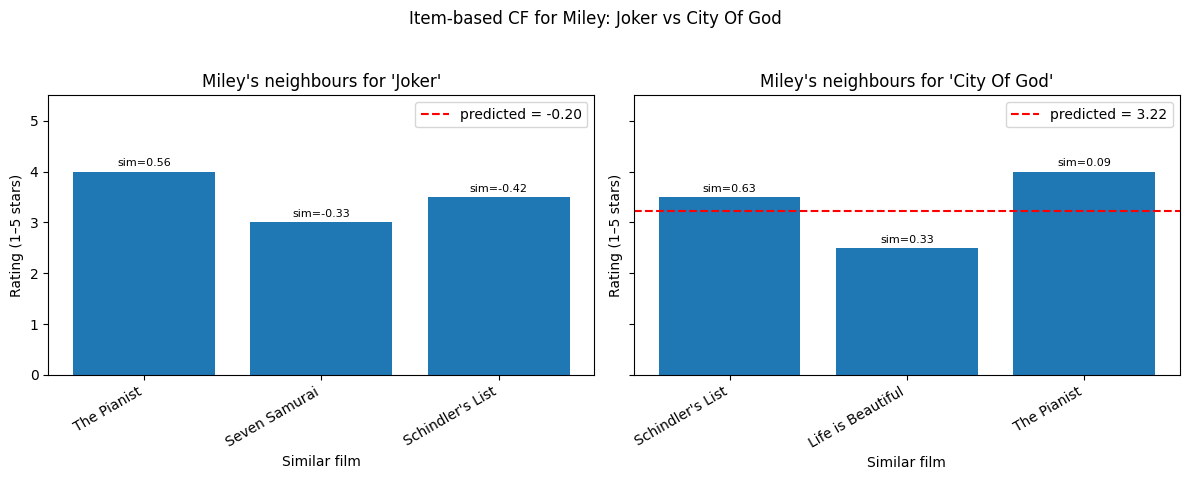

Item-based CF predictions for Miley:
  Joker: -0.20
  City Of God: 3.22


In [51]:
demo_item_based_for_miley_side_by_side(df, sim_func=pearson, k=3)

In [61]:
def plot_item_triangle_for_user(points, weights, labels,
                                user_name="Miley",
                                target_film="Joker",
                                target_point=None,
                                xy_labels=None,
                                title="Item-based barycentric interpolation"):
    """
    points  : array-like (3, 2)
              -> (user rating, avg rating by others) for 3 neighbour films
    weights : array-like (3,)
              -> similarity weights between neighbour films and target film
    labels  : list of 3 neighbour film names
    target_point: optional (x,y) to plot (if known)
    xy_labels: optional (xlabel, ylabel)
    """

    points = np.asarray(points, float)
    weights = np.asarray(weights, float)

    # Use non-negative weights for clean barycentric geometry
    w = np.abs(weights)
    if np.allclose(w.sum(), 0):
        w_norm = np.ones_like(w) / 3.0
    else:
        w_norm = w / w.sum()

    # Barycentric prediction
    p_pred = (w_norm[:, None] * points).sum(axis=0)

    fig, ax = plt.subplots(figsize=(5, 5))

    # Draw triangle
    tri = np.vstack([points, points[0]])
    ax.plot(tri[:, 0], tri[:, 1], "k--", alpha=0.4)

    # Neighbour films (vertices)
    ax.scatter(points[:, 0], points[:, 1], s=120,
               c="tab:green", label="neighbour films")

    for (x, y), name, wn in zip(points, labels, w_norm):
        ax.text(x, y + 0.07, f"{name}\nw={wn:.2f}",
                ha="center", va="bottom", fontsize=9)

    # Predicted point
    ax.scatter(p_pred[0], p_pred[1], s=160, c="red", marker="*",
               label=f"predicted for '{target_film}'")
    ax.text(p_pred[0], p_pred[1] - 0.08, "prediction",
            ha="center", va="top", fontsize=9)

    # Optional true/target point
    if target_point is not None:
        tp = np.asarray(target_point, float)
        ax.scatter(tp[0], tp[1], s=120, c="tab:blue", marker="X", label="target")
        ax.text(tp[0], tp[1] - 0.08, "target", ha="center", va="top", fontsize=9)

    # Guide lines
    for (x, y) in points:
        ax.plot([x, p_pred[0]], [y, p_pred[1]], "gray", alpha=0.3)

    # Labels
    if xy_labels is None:
        ax.set_xlabel(f"{user_name}'s rating")
        ax.set_ylabel("Average rating by others")
    else:
        ax.set_xlabel(xy_labels[0])
        ax.set_ylabel(xy_labels[1])

    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0.5, 5.5)
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()

    return p_pred

In [63]:
import numpy as np
import math

def demo_item_based_triangle_for_film(
    target_film="Joker",
    user="Miley",
    ratings=df,
    sim_func=pearson,
    k=3
):
    """
    Show item-based CF as barycentric interpolation of neighbour films
    in a 2D space:
        x = Miley's rating on the film
        y = average rating by all other users on the film
    """
    if target_film not in ratings.columns:
        print(f"Film '{target_film}' not found.")
        return
    if user not in ratings.index:
        print(f"User '{user}' not found.")
        return

    # 1) find candidate neighbour films:
    #    must be != target_film and must be rated by user
    candidates = []
    for other_film in ratings.columns:
        if other_film == target_film:
            continue
        # user must have rated this film
        r_u_other = ratings.loc[user, other_film]
        if np.isnan(r_u_other):
            continue

        x, y = common_ratings_items(target_film, other_film, ratings)
        if x is None or len(x) == 0:
            continue

        s = sim_func(x, y)  # item similarity
        candidates.append((other_film, s))

    if len(candidates) < 3:
        print(f"Not enough neighbour films for '{target_film}'.")
        return

    # 2) take top-k neighbours by similarity
    candidates.sort(key=lambda t: t[1], reverse=True)
    neighbours = candidates[:k]
    neighbour_names = [f for f, _ in neighbours]
    weights = np.array([s for _, s in neighbours], float)

    # 3) build 2D coordinates for each neighbour film:
    #    x = Miley's rating, y = average rating by others
    other_users = [u for u in ratings.index if u != user]
    coords = []
    for film in neighbour_names:
        r_user = ratings.loc[user, film]
        r_others = ratings.loc[other_users, film].dropna()
        if len(r_others) == 0:
            avg_others = np.nan
        else:
            avg_others = r_others.mean()
        coords.append([r_user, avg_others])
    coords = np.array(coords, float)

    print(f"Target film: {target_film}")
    print(f"Target user: {user}")
    print("Neighbour films (used for barycentric combination):")
    for name, w, (rx, ry) in zip(neighbour_names, weights, coords):
        print(f"  {name:20s} sim={w:.3f},  {user} rating={rx:.1f},  others avg={ry:.2f}")

    # 4) use triangle interpolation to visualise
    #    The x-coordinate of the barycentric point is the predicted rating
    from math import isnan

    # normalise weights for barycentric combination
    w_abs = np.abs(weights)
    if np.allclose(w_abs.sum(), 0):
        w_norm = np.ones_like(w_abs) / len(w_abs)
    else:
        w_norm = w_abs / w_abs.sum()

    p_pred = (w_norm[:, None] * coords).sum(axis=0)
    pred_rating = p_pred[0]

    # call your generic triangle plotting helper
    plot_item_triangle_for_user(
        points=coords,
        weights=weights,
        labels=neighbour_names,
        target_point=None,  # we don't know true Joker location in this space for Miley yet
        xy_labels=(f"{user}'s rating", "Avg rating by others"),
        title=f"Item-based CF: '{target_film}' as barycentric blend of neighbour films"
    )

    print(f"\nBarycentric prediction for {user} on '{target_film}':")
    print(f"  predicted rating ≈ {pred_rating:.2f}")

Target film: Joker
Target user: Miley
Neighbour films (used for barycentric combination):
  The Pianist          sim=0.556,  Miley rating=4.0,  others avg=3.30
  Seven Samurai        sim=-0.333,  Miley rating=3.0,  others avg=3.83
  Schindler's List     sim=-0.423,  Miley rating=3.5,  others avg=4.08


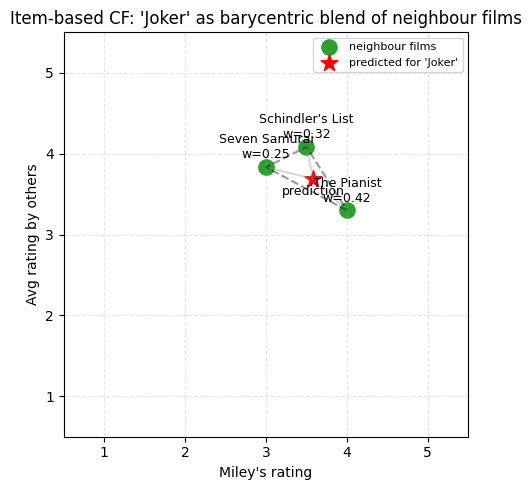


Barycentric prediction for Miley on 'Joker':
  predicted rating ≈ 3.58
Target film: City Of God
Target user: Miley
Neighbour films (used for barycentric combination):
  Schindler's List     sim=0.633,  Miley rating=3.5,  others avg=4.08
  Life is Beautiful    sim=0.333,  Miley rating=2.5,  others avg=2.88
  The Pianist          sim=0.086,  Miley rating=4.0,  others avg=3.30


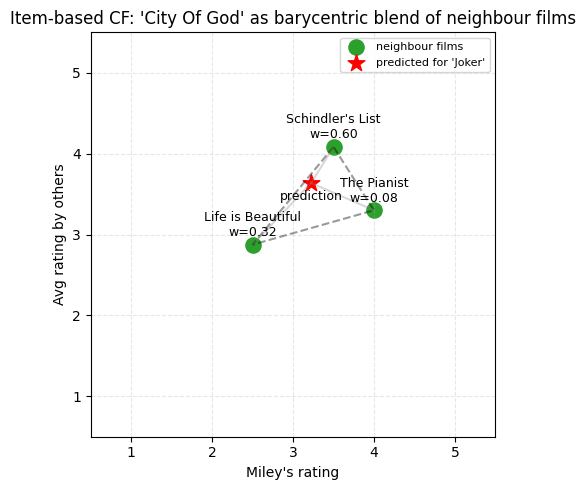


Barycentric prediction for Miley on 'City Of God':
  predicted rating ≈ 3.22


In [64]:
demo_item_based_triangle_for_film("Joker",   user="Miley", ratings=df, sim_func=pearson, k=3)
demo_item_based_triangle_for_film("City Of God", user="Miley", ratings=df, sim_func=pearson, k=3)